In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import preprocessing libraries
import re
import string
import spacy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/text-preprocessing-tools-light/stopwords.txt
/kaggle/input/text-preprocessing-tools-light/lemmatization-en.json


## Loading training and test data

In [58]:
%cd /kaggle/input

/kaggle/input


In [59]:
data_train = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv.zip')
data_test = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_label = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
sample_submission = pd.read_csv('jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

In [60]:
with open("text-preprocessing-tools-light/lemmatization-en.json") as file:
    lemmatizer = json.load(file)

with open("text-preprocessing-tools-light/stopwords.txt") as file:
    stopwords = file.read().splitlines()

In [61]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


## Examine the data (EDA)

In [62]:
data_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [63]:
data_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [65]:
data_classify = {}
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, col in enumerate(classes):
    data_classify[col + '_cmt'] = data_train[data_train[col] == 1]['comment_text'].values
#     data_classify[col + '_cmt_len'] = [len(x) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_word_count'] = [len(x.split()) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_unique_word_count'] = [len(set(x.split())) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_stopword_count'] = [len([w for w in x.split() if w in STOPWORDS]) for x in data_classify[col + '_cmt']]

In [66]:
data_classify['identity_hate_cmt'][0]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [67]:
# data_classify.head()

In [68]:
for col in classes:
    print(col, len(data_classify[col + '_cmt']))

toxic 15294
severe_toxic 1595
obscene 8449
threat 478
insult 7877
identity_hate 1405


## Visualize meta features of each class

In [69]:
# clean_cmt = data_train[data_train[classes].sum(axis = 1) == 0]
# clean_cmt
df = data_train.copy()
df['clean'] = (df.iloc[:,2:].sum(axis=1) == 0)

In [70]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
    
META_FEATURES  = ['count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'word_unique_percent', 'punct_percent']

df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

#### Rescale extreme cases

In [71]:
df.loc[df['count_sent']>10, 'count_sent'] = 10 
df.loc[df['count_word'] > 200, 'count_word'] = 200
df.loc[df['count_unique_word'] > 200, 'count_unique_word'] = 200
df.loc[df['count_letters'] > 1000, 'count_letters'] = 1000
df.loc[df['count_punctuations'] > 50, 'count_punctuations'] = 50
df.loc[df['count_words_upper'] > 30, 'count_words_upper'] = 30
df.loc[df['count_words_title'] > 30, 'count_words_title'] = 30
df.loc[df['count_stopwords'] > 100, 'count_stopwords'] = 100
df.loc[df['mean_word_len'] > 10, 'mean_word_len'] = 10

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


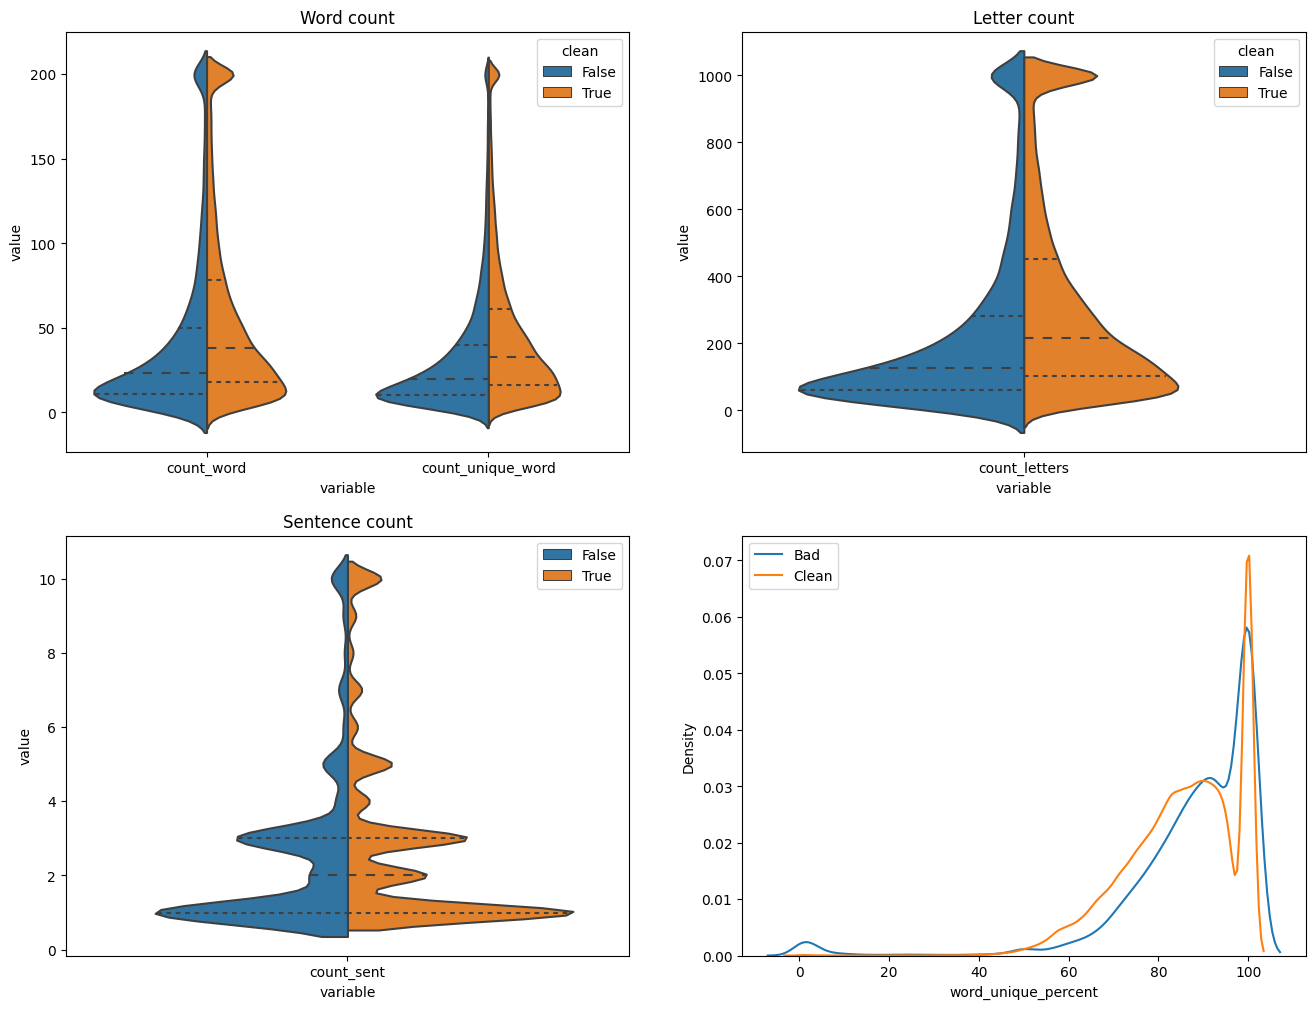

In [72]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.title('Word count')
temp_df = pd.melt(df, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
sns.violinplot(data=temp_df, y = 'value', x = 'variable', hue = 'clean', split = True, inner = 'quart')
plt.subplot(2, 2, 2)
plt.title('Letter count')
temp_df = pd.melt(df, value_vars=['count_letters'], id_vars='clean')
sns.violinplot(data=temp_df, y = 'value', x = 'variable', hue = 'clean', split = True, inner = 'quart')
plt.subplot(2, 2, 3)
plt.title('Sentence count')
temp_df = pd.melt(df, value_vars=['count_sent'], id_vars='clean')
sns.violinplot(data=temp_df, y = 'value', x = 'variable', hue = 'clean', split = True, inner = 'quart')
plt.legend()
plt.subplot(2, 2, 4)
sns.kdeplot(df[df.clean == 0].word_unique_percent, label="Bad")
sns.kdeplot(df[df.clean == 1].word_unique_percent, label="Clean")
plt.legend()


### Length

In [73]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_len'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 1000:
#             data_classify[col + feat][i] = 1000
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

### Word Count

In [74]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_word_count'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 200:
#             data_classify[col + feat][i] = 200
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

### Unique Word Count

In [75]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_unique_word_count'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 100:
#             data_classify[col + feat][i] = 100
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

## Correlation of features and targets

<Axes: title={'center': 'Correlation of features & targets'}>

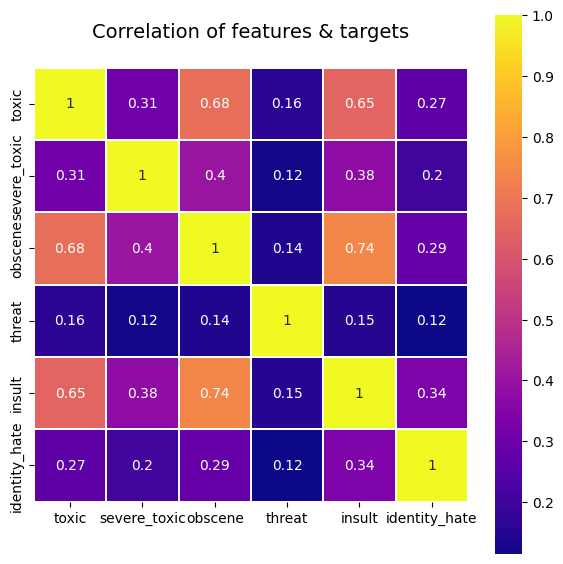

In [76]:
# This block uses Pearson Correlation, which doesn't work with categorical data
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data_train[classes].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [77]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Create a cross-tabulation table
cross_tab = pd.crosstab(df['toxic'], df['severe_toxic'])

# Calculate the chi-square statistic and p-value
chi2, p, _, _ = chi2_contingency(cross_tab)

# Calculate Cramér's V
n = cross_tab.sum().sum()
v = np.sqrt(chi2 / (n * (min(cross_tab.shape) - 1)))

# Print the correlation
print("Cramér's V:", v)


Cramér's V: 0.3085120954599085


## Clean the text

In [78]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [79]:
# nlp = spacy.load("en_core_web_sm")

def split_numbers_from_characters(text):
    # Split numbers and characters
    parts = re.split('(\d+)', text)
    
    # If there was a number and a character part, add a space between them
    if len(parts) > 1:
        return ' '.join(parts)
    
    # If there was no number, return the original text
    return text

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non ascii characters
    text = re.sub(r'[^\x00-\x7f]', r' ', text)
    # Remove special characters
    # text = re.sub(r'\W', ' ', text)
    # Remove \n\r
    text= re.sub(r'/\\n+|\\r+|\n+|\r+/', r' ', text)
    # Remove leaky elements like ip,user
    # text=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",text)
    # Removing usernames
    # text=re.sub("\[\[.*\]","",text)
    # Remove emojis
#     text = re.sub(r'[\U00010000-\U0010ffff]', ' ', text, flags=re.UNICODE)
    
    # Remove punctuation
    text = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', ' ', text)
    
    # Remove numbers
    text = split_numbers_from_characters(text)
    text = re.sub(r'\d', ' ', text)
    # Replace appos
    words=[APPO[word] if word in APPO else word for word in text.split()]
    # lemmatization
#     words = [lemmatizer.get(word, word) for word in words]
    # Remove stopwords
#     words = [word for word in words if word not in stopwords]
    return ' '.join(words)

In [80]:
data_classify['identity_hate_cmt']

array(["You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",
       'A pair of jew-hating weiner nazi schmucks.',
       "I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms",
       ...,
       "Shalom \n\nSemite, get the fuck out of here. I will kill you, you son of a bitch if you don't leave wikipedia. If y

In [81]:
clean_text(data_classify['identity_hate_cmt'][0])

'you are gay or antisemmitian archangel white tiger meow greetingshhh uh there are two ways why you do erased my comment about ww that holocaust was brutally slaying of jews and not gays gypsys slavs anyone if you are anti semitian than shave your head bald and go to the skinhead meetings if you doubt words of the bible that homosexuality is a deadly sin make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals first and last warning you fucking gay i won t appreciate if any more nazi shwain would write in my page i don t wish to talk to you anymore beware of the dark side'

In [82]:
data_train['comment_text'] = data_train['comment_text'].apply(clean_text)
data_test['comment_text'] = data_test['comment_text'].apply(clean_text)
labels = data_train.drop(['id', 'comment_text'], axis = 1)
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [83]:
data_train['comment_text'].values

array(['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now',
       'd aww he matches this background colour i m seemingly stuck with thanks talk january utc',
       'hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info',
       ...,
       'spitzer umm theres no actual article for prostitution ring crunch captain',
       'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it',
       'and i really don t think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them'],

In [84]:
# combined = pd.concat([data_train['comment_text'], data_test['comment_text']], axis=0)
# combined.describe()

In [85]:
# %cd d:/python/Toxic-comment-classification

In [86]:
# data_train.to_json('clean_data/data_train_cleaned_ver2.json')
# data_test.to_json('clean_data/data_test_cleaned_ver2.json')
# # labels.to_json('clean_data/labels.json')

In [87]:
# try:
#     data_train = pd.read_json('clean_data/data_train_cleaned.json')
#     data_test = pd.read_json('clean_data/data_test_cleaned.json')
#     labels = pd.read_json('clean_data/labels.json')
# except:
#     print('No such file')


## Split the data

In [88]:
# from skmultilearn.model_selection import iterative_train_test_split
# X_train, y_train, X_test, y_test = iterative_train_test_split(data_train, labels, test_size = 0.1)

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_train, labels, test_size = 0.2, random_state = 42)

## Apply TF_IDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_features = 100000, ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True, smooth_idf=True, sublinear_tf=True)
train_term_doc = vec.fit_transform(X_train['comment_text'])
val_term_doc = vec.transform(X_val['comment_text'])
test_term_doc = vec.transform(data_test['comment_text'])
vec.get_feature_names_out()

array(['aa', 'aa aa', 'aa acupuncture', ...,
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

In [110]:
vec.get_feature_names_out().shape

(2004456,)

In [91]:
train_term_doc, test_term_doc

(<127656x2004456 sparse matrix of type '<class 'numpy.float64'>'
 	with 12895183 stored elements in Compressed Sparse Row format>,
 <153164x2004456 sparse matrix of type '<class 'numpy.float64'>'
 	with 11765394 stored elements in Compressed Sparse Row format>)

In [92]:
# from scipy.sparse import csr_matrix, hstack
# stack meta features with term-doc matrix
# x = hstack(trn_term_doc, df[META_FEATURES]).tocsr()
X_train = train_term_doc
X_val = val_term_doc
del train_term_doc
del val_term_doc

## Modeling

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [104]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, solver = 'lbfgs', dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.solver = solver
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(solver = self.solver, C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self


In [95]:
# def pr(y_i, y):
#     p = x[y==y_i].sum(0)
#     return (p+1) / ((y==y_i).sum()+1)

# def get_mdl(y):
#     y = y.values
#     r = np.log(pr(1,y) / pr(0,y))
#     model = LogisticRegression()
#     x_nb = x.multiply(r)
#     return model.fit(x_nb, y), r

# def get_model(y):
#     y = y.values
#     model = MultinomialNB()
#     return model.fit(x, y)

In [105]:
# preds = np.zeros((len(test), len(classes)))
models = []
for i, col in enumerate(classes):
    print(col)
    models.append(NbSvmClassifier(solver = 'liblinear', C=4, n_jobs=-1).fit(X_train, y_train[col]))
    preds = models[i].predict_proba(X_val)[:,1].reshape(-1, 1)
    print(roc_auc_score(y_val, preds))

toxic
0.9787238183611272
severe_toxic
0.9254786916219662
obscene


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9622104977731591
threat
0.8498665439873848
insult


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9654623620005482
identity_hate
0.9246277634133389


In [97]:
# preds = np.zeros((len(test), len(clas)))
# model = []
# for i, col in enumerate(classes):
#     print(col)
#     model.append(get_model(train_labels[col]))
#     preds= model[i].predict_proba(val_x)[:,1].reshape(-1, 1)
#     print(roc_auc_score(valid_labels, preds))

In [106]:
preds = np.zeros((len(data_test), len(classes)))

for i, col in enumerate(classes):
    print(col)
    preds[:, i] = models[i].predict_proba(test_term_doc)[:, 1]

toxic
severe_toxic
obscene
threat
insult
identity_hate


In [107]:
%cd /kaggle/working

/kaggle/working


In [108]:
submid = pd.DataFrame({'id': sample_submission["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = classes)], axis=1)
submission.to_csv('submission.csv', index=False)